In [1]:
import numpy as np
import cv2
#import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle
import matplotlib.pyplot as plt
import math
import os
import glob
%matplotlib inline

## Discussion
### Briefly discuss any problems / issues you faced in your implementation of this project. Where will your pipeline likely fail? What could you do to make it more robust?

   * The below code defined only works as far the perspective transform is correct. To make the pipeline better I think I need a better way at identifying perspective transform. 
   * My algorithm current will fail if it wrongly identifies a lane that is farther right or left.
   * There is no correction mechanism currently built into the algorithm.
   * The algorithm worked ok under bright light conditions, because I have tried to use S channel of HLS image and V channel of HSV image. 
   * I have avoided to use lane colors as identification factor, instead have relied on Gradient based operators to pull lines from S and V channels.
   * But the problem with that is a line in between lanes can also be identified mistakenly. Thus Algorithm not only identifies lane lines but also other horizontal lines. 
   * I have used lane width as a measure of sanity check and hence this is highly customized to the project video and will not work on other challenge videos. 
  

### Camera Calibration
#### 1. Briefly state how you computed the camera matrix and distortion coefficients. Provide an example of a distortion corrected calibration image.

#### Answer:
   * The below code takes a 9x6 chessboard images, then calibrates and undistorts it. 
   * The undistorted images are saved to camera_cal folder.
   * The distortion matrix is then saved to a pickle file for later use in the camera_cal folder. 

In [2]:
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32) #Define the Chess corners to be 9x6
objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        cv2.drawChessboardCorners(img, (9,6), corners, ret)
        write_name = 'camera_cal/corners_found'+str(idx)+'.jpg'
        cv2.imwrite(write_name, img)

   * I then used the output objpoints and imgpoints to compute the camera calibration and distortion coefficients using the cv2.calibrateCamera() function. I applied this distortion correction to the test image using the cv2.undistort() function and obtained this result:

In [3]:
img = cv2.imread(images[11]) 
#Load images with Corners drawn
corner_image = glob.glob('camera_cal/corners_found*.jpg')
corner = cv2.imread(corner_image[2]) 
img_size = (img.shape[1], img.shape[0])
#plt.imshow(corner)

In [4]:
#Get the undistortion coefficients
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)
#Undistort an image
undistorted_img = cv2.undistort(img, mtx, dist, None, mtx)

# Save the camera calibration result for later use 
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump( dist_pickle, open( "camera_cal/wide_dist_pickle.p", "wb" ))

(-0.5, 1279.5, 719.5, -0.5)

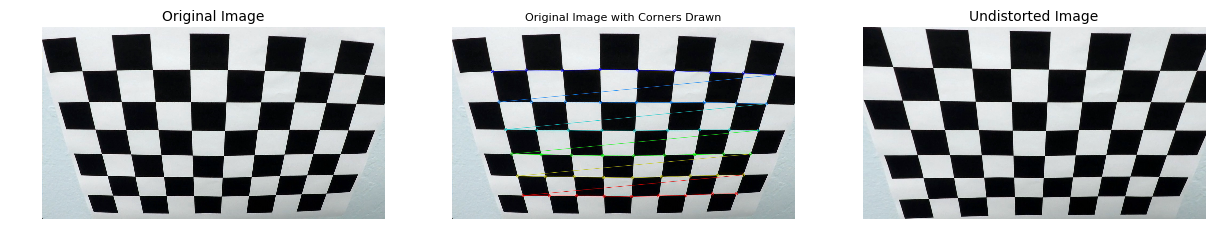

In [5]:
fig, axes = plt.subplots(1, 3, figsize = (15, 10))
axes.flat[0].imshow(img)
axes.flat[0].set_title("Original Image", fontsize = 10)
axes.flat[0].axis('off')
axes.flat[1].imshow(corner)
axes.flat[1].set_title("Original Image with Corners Drawn", fontsize = 8)
axes.flat[1].axis('off')
axes.flat[2].imshow(undistorted_img)
axes.flat[2].set_title("Undistorted Image", fontsize = 10)
axes.flat[2].axis('off')


### Pipeline (single images)
Below section addresses the following rubric:
### 1. Provide an example of a distortion-corrected image.


(-0.5, 1279.5, 719.5, -0.5)

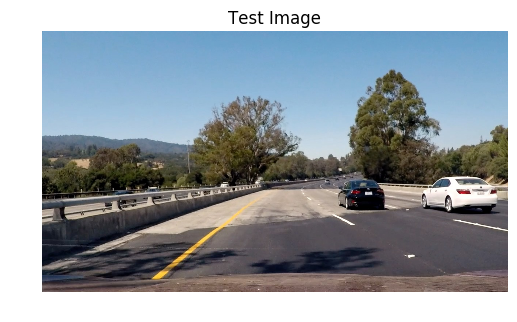

In [6]:
#Load the Test Images 
list_image = os.listdir("test_images/")
Sample_Image = mpimg.imread('test_images/'+list_image[5])

plt.imshow(Sample_Image)
plt.title("Test Image", fontsize = 12)
plt.axis('off')

(-0.5, 1279.5, 719.5, -0.5)

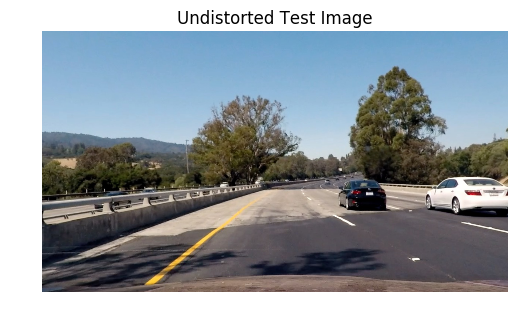

In [7]:
undistorted_test_img = cv2.undistort(Sample_Image, mtx, dist, None, mtx)
plt.imshow(undistorted_test_img)
plt.title("Undistorted Test Image", fontsize = 12)
plt.axis('off')

### 2. Describe how (and identify where in your code) you performed a perspective transform and provide an example of a transformed image.

#### Define the Warp Image function

#### Perspective Transform using Trial and Error Method as listed below

In [8]:
def warp_image(img, mtx, dist):
    """Undistort the image using camera calibration matrix and vector of distortion coefficients
    and then apply perspective transform and warp the image"""
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    #print(img.dtype)

    # Grab the image shape
    img_size = (img.shape[1], img.shape[0])
    
    #Original image Trapezium Region of Interest
    bottom_width = 0.76 #percent of bottom trapezoid height
    mid_width = 0.13 #percent of middle trapezoid height
    height_pct = 0.64 #percent of trapezoid height
    bottom_trim = 0.95 #bottom trim to avoid hood
        
    #Define Source Points
    src = np.float32([[img.shape[1]*(0.5-mid_width/2),img.shape[0]*height_pct],[img.shape[1]*(0.5+mid_width/2),img.shape[0]*height_pct], [img.shape[1]*(0.5+bottom_width/2),img.shape[0]*bottom_trim],[img.shape[1]*(0.5-bottom_width/2),img.shape[0]*bottom_trim]])
    offset = img.shape[1]*0.27 # offset for dst points

    #Define Destination Points
    dst = np.float32([[offset, 0], [img_size[0]-offset, 0], [img_size[0]-offset, img_size[1]], [offset, img_size[1]]])
 
    # Given src and dst points, calculate the perspective transform matrix
    M = cv2.getPerspectiveTransform(src, dst)                  
    Minv = cv2.getPerspectiveTransform(dst, src)
                     
    # Warp the image using OpenCV warpPerspective()
    warped = cv2.warpPerspective(undist, M, img_size, flags=cv2.INTER_LINEAR)
    
    return warped, M, Minv

#### Test Image After Perspective Transform on Undistorted Image

(-0.5, 1279.5, 719.5, -0.5)

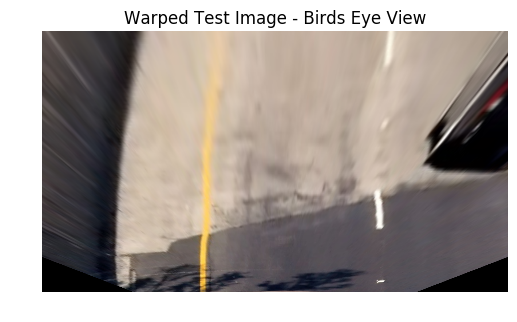

In [9]:
sample_warped, M_sample, Minv_sample = warp_image(undistorted_test_img, mtx, dist)
plt.imshow(sample_warped)
plt.title("Warped Test Image - Birds Eye View", fontsize = 12)
plt.axis('off')

### 3. Describe how (and identify where in your code) you used color transforms, gradients or other methods to create a thresholded binary image. Provide an example of a binary image result.

In [10]:
#Define the Various Sobel Operator Functions, Takes in 1 channel images

def abs_sobel_thresh(img, sobel_kernel=3, orient='x', thresh=(0, 255)):
    """ Define a function that applies Sobel x or y, 
    # then takes an absolute value and applies a threshold.
    # Note: calling your function with orient='x', thresh_min=5, thresh_max=100"""
    
    # Apply the following steps to img
    gray = img
    #gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    if orient == 'x':
        sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0,  ksize=sobel_kernel)
        abs_sobelx = np.absolute(sobelx)
        scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    elif orient == 'y':
        sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1,  ksize=sobel_kernel)
        abs_sobely = np.absolute(sobely)
        scaled_sobel = np.uint8(255*abs_sobely/np.max(abs_sobely))
    # 3) Take the absolute value of the derivative or gradient
    
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    # 5) Create a mask of 1's where the scaled gradient magnitude 
            # is > thresh_min and < thresh_max
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    # 6) Return this mask as your binary_output image
    #binary_output = np.copy(img) # Remove this line
    return sxbinary


def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    """# Define a function that applies Sobel x and y, 
    # then computes the direction of the gradient
    # and applies a threshold."""
    gray = img
    #gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    abs_sobelx = np.absolute(sobelx)
    #abs_sobelx = np.absolute(sobelx)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1,ksize=sobel_kernel)
    abs_sobely = np.absolute(sobely)
    #abs_sobely = np.absolute(sobely)
    #abs_sobelxy =np.sqrt(np.square(sobelx)+np.square(sobely))
    scaled_sobel=np.arctan2(abs_sobely, abs_sobelx)
    #scaled_sobel = np.uint8(255*abs_sobelxy/np.max(abs_sobelxy))
    #print((scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1]))
    #print(scaled_sobel.shape)
    #print(np.max(scaled_sobel), np.min(scaled_sobel))
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    return sxbinary
    
def hls_thershold(image, thresh=(0, 255)):
    """# Define a function that and applies a threshold."""
    binary = np.zeros_like(image)
    binary[(image > thresh[0]) & (image <= thresh[1])] = 1
    return binary

1. The below function called Edge finding uses various techniques taught in the class to find edges and lines in the image. 
2. The below function uses S channel of HLS  image and V channel of HSV image to iminize the effect of lightings in the image. 
3. Sobel operators in x directions are great at identifying lines that are vertical to the image, and since most road lanes are vertical sobel x operator is been used.
3. Combined with thresholding of images on values and also using the direction of the gradient for more robust lane finding. 

In [11]:
#Edge Finding Algorithm

def edge_finding(image):
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    hls_s = hls[:,:,2]
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    hsv_v = hsv[:,:,2]
    #plt.imshow(hls_s,cmap="gray")
    gradx = abs_sobel_thresh(hls_s, orient='x', sobel_kernel=5, thresh=(20, 100))
    gradx2 = abs_sobel_thresh(hsv_v, orient='x', sobel_kernel=5, thresh=(20, 230))
    gradx[(gradx == 1) | (gradx2 == 1)] = 1
    dir_binary = dir_threshold(hls_s, sobel_kernel=15, thresh=(0.7, 1.3))
    combined = np.zeros_like(dir_binary)
    combined[(gradx == 1) & (dir_binary == 1)] = 1
    hls_thresholded = hls_thershold(hls_s, thresh=(120, 255))
    combined_2 = np.zeros_like(dir_binary)
    combined_2[((combined == 1) | hls_thresholded == 1) &  (gradx == 1)] = 1
    return combined_2
    

(-0.5, 1279.5, 719.5, -0.5)

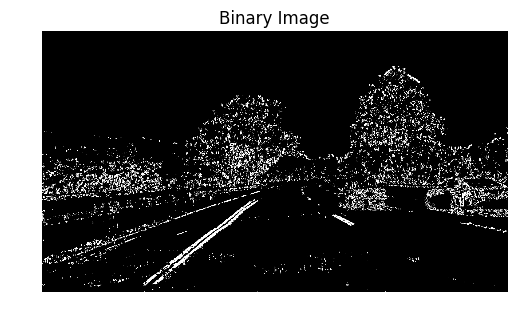

In [12]:
binary = edge_finding(undistorted_test_img)
binary = binary.astype(np.uint8)
plt.imshow(binary, cmap="gray") 
plt.title("Binary Image", fontsize = 12)
plt.axis('off')

### 4. Describe how (and identify where in your code) you identified lane-line pixels and fit their positions with a polynomial?

The below code finds the lane lines using convolutions. The window centroids are then used to plot the lane line. 

In [13]:
def window_mask(width, height, img_ref, center,level):
    output = np.zeros_like(img_ref)
    output[int(img_ref.shape[0]-(level+1)*height):int(img_ref.shape[0]-level*height),max(0,int(center-width/2)):min(int(center+width/2),img_ref.shape[1])] = 1
    return output

def find_window_centroids(warped, window_width, window_height, margin):
    
    window_centroids = [] # Store the (left,right) window centroid positions per level
    window = np.ones(window_width) # Create our window template that we will use for convolutions
    
    # First find the two starting positions for the left and right lane by using np.sum to get the vertical image slice
    # and then np.convolve the vertical image slice with the window template 
    
    # Sum quarter bottom of image to get slice, could use a different ratio
    l_sum = np.sum(warped[int(3*warped.shape[0]/4):,:int(warped.shape[1]/2)], axis=0)
    l_center = np.argmax(np.convolve(window,l_sum))-window_width/2
    r_sum = np.sum(warped[int(3*warped.shape[0]/4):,int(warped.shape[1]/2):], axis=0)
    r_center = np.argmax(np.convolve(window,r_sum))-window_width/2+int(warped.shape[1]/2)
    #print(l_center,r_center)
    
    lane_width = r_center-l_center
    # Check for the lane width not greater than 12 feet 
    if lane_width > 100 and lane_width < 650:
        window_centroids.append((l_center,r_center))
    else:
        l_center = int(warped.shape[1]/2)-175
        r_center = int(warped.shape[1]/2)+200
        window_centroids.append((l_center,r_center))
        
    # Go through each layer looking for max pixel locations
    for level in range(1,(int)(warped.shape[0]/window_height)):
        #Save the Left and Right Centroids for cases where road width is more than 12 feet
        copy_l_center = l_center
        copy_r_center = r_center                  
                    
        # convolve the window into the vertical slice of the image
        image_layer = np.sum(warped[int(warped.shape[0]-(level+1)*window_height):int(warped.shape[0]-level*window_height),:], axis=0)
        image_level = warped[int(warped.shape[0]-(level+1)*window_height):int(warped.shape[0]-level*window_height),:]
        #plt.imshow(image_level, cmap='gray')
        conv_signal = np.convolve(window, image_layer)
        # Find the best left centroid by using past left center as a reference
        # Use window_width/2 as offset because convolution signal reference is at right side of window, not center of window
        offset = window_width/2
        l_min_index = int(max(l_center+offset-margin,0))
        l_max_index = int(min(l_center+offset+margin,warped.shape[1]))        
        l_center = np.argmax(conv_signal[l_min_index:l_max_index])+l_min_index-offset
                   
        # Find the best right centroid by using past right center as a reference
        r_min_index = int(max(r_center+offset-margin,0))
        r_max_index = int(min(r_center+offset+margin,warped.shape[1]))        
        r_center = np.argmax(conv_signal[r_min_index:r_max_index])+r_min_index-offset
        
        prev_lane_width = copy_r_center - copy_l_center
        lane_width = r_center-l_center
        # Check for the lane width not greater than 12 feet 
        if lane_width > (prev_lane_width-20) and lane_width < (prev_lane_width+20):                    
            window_centroids.append((l_center,r_center))
            #print(l_center, r_center)
        else:
            #print("Width greater than 12 feet")
            window_centroids.append((copy_l_center,copy_r_center))       
        
    return window_centroids

#### Example Test Image with line pixels identified

(-0.5, 1279.5, 719.5, -0.5)

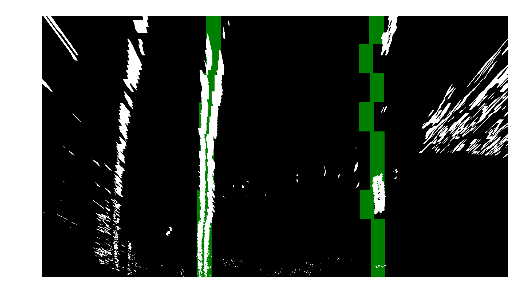

In [14]:
sample_warped, M_sample, Minv_sample = warp_image(binary, mtx, dist)
# window settings
window_width = 40
window_height = 80 # Break image into 9 vertical layers since image height is 720
margin = 30 # How much to slide left and right for searching

#Window Centroids used for left and right lane
leftx = []  
rightx = [] 

window_centroids = find_window_centroids(sample_warped, window_width, window_height, margin)
warped = sample_warped

if len(window_centroids) > 0:
    # Points used to draw all the left and right windows
    l_points = np.zeros_like(warped)
    r_points = np.zeros_like(warped)

    # Go through each level and draw the windows 	
    for level in range(0,len(window_centroids)):
        #Add the window center points to the list of left and right lane points 
        leftx.append(window_centroids[level][0])
        rightx.append(window_centroids[level][1])
        
        # Window_mask is a function to draw window areas
        l_mask = window_mask(window_width,window_height,warped,window_centroids[level][0],level)
        r_mask = window_mask(window_width,window_height,warped,window_centroids[level][1],level)
        # Add graphic points from window mask here to total pixels found 
        l_points[(l_points == 255) | ((l_mask == 1) ) ] = 255
        r_points[(r_points == 255) | ((r_mask == 1) ) ] = 255

    # Draw the results
    template = np.array(r_points+l_points,np.uint8) # add both left and right window pixels together
    zero_channel = np.zeros_like(template) # create a zero color channe l
    template = np.array(cv2.merge((zero_channel,template,zero_channel)),np.uint8) # make window pixels green
    warpage = np.dstack((warped, warped, warped))*255
    output = cv2.addWeighted(warpage, 1, template, 0.5, 0.0) # overlay the orignal road image with window results
plt.imshow(output)
plt.axis('off')

### 5. Describe how (and identify where in your code) you calculated the radius of curvature of the lane and the position of the vehicle with respect to center.
I have did that in the Image processing function under the comments "Calculate the Radius of Curvature". The below code is only for representation and plotting. 

C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:8: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(-0.5, 1279.5, 719.5, -0.5)

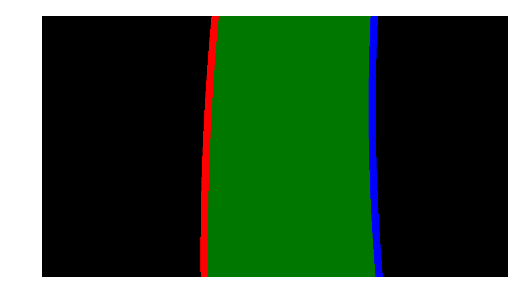

In [15]:
#Curve fitting
y_value = range(0, warped.shape[0])
res_yvalue = np.arange(warped.shape[0]-(window_height/2),0,-window_height)#define the range of 

# Fit a second order polynomial to pixel positions of left and right lane lines respectively
left_fit = np.polyfit(res_yvalue, leftx, 2)

left_fitx = left_fit[0]*y_value*y_value + left_fit[1]*y_value + left_fit[2]
left_fitx = left_fitx.astype(np.int32)

right_fit = np.polyfit(res_yvalue, rightx, 2)

right_fitx = right_fit[0]*y_value*y_value + right_fit[1]*y_value + right_fit[2]
right_fitx = right_fitx.astype(np.int32)


left_lane = np.array(list(zip(np.concatenate((left_fitx-window_width/4,left_fitx[::-1]+window_width/4), axis=0),np.concatenate((y_value,y_value[::-1]),axis=0))), np.int32)
right_lane = np.array(list(zip(np.concatenate((right_fitx-window_width/4,right_fitx[::-1]+window_width/4), axis=0),np.concatenate((y_value,y_value[::-1]),axis=0))), np.int32)
middle_marker = np.array(list(zip(np.concatenate((left_fitx+window_width/4,right_fitx[::-1]-window_width/4), axis=0),np.concatenate((y_value,y_value[::-1]),axis=0))), np.int32)

road_sample= np.zeros_like(undistorted_test_img)
#road_bg= np.zeros_like(image)

cv2.fillPoly(road_sample,[left_lane], color=[255,0,0])
cv2.fillPoly(road_sample,[right_lane], color=[0,0,255])
cv2.fillPoly(road_sample,[middle_marker], color=[0,120,0])
plt.imshow(road_sample)
plt.axis('off')

### 6. Provide an example image of your result plotted back down onto the road such that the lane area is identified clearly.
I have did that in the Image processing function under the comments "Calculate the Radius of Curvature". The below code is only for representation and plotting. 

(-0.5, 1279.5, 719.5, -0.5)

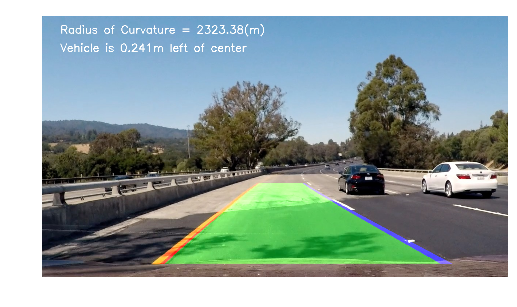

In [16]:
#img_size = (image.shape[1], image.shape[0])
road_sample_warped = cv2.warpPerspective(road_sample,Minv_sample,img_size, flags=cv2.INTER_LINEAR)
result_sample = cv2.addWeighted(Sample_Image, 1, road_sample_warped, 1.0, 0.0) 

#Measure Radius of Curvature

# Define conversions in x and y from pixels space to meters
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension

# Fit new polynomials to x,y in world space
curve_fit = np.polyfit(np.array(res_yvalue,np.float32)*ym_per_pix, np.array(leftx,np.float32)*xm_per_pix, 2)
#Calculate the Curve Radius
left_curverad = ((1 + (2*curve_fit[0]*y_value[-1]*ym_per_pix + curve_fit[1])**2)**1.5) / np.absolute(2*curve_fit[0])

#Calculate the offset of the car on the road
camera_center = (left_fitx[-1]+right_fitx[-1])/2
center_diff = (camera_center - warped.shape[1]/2)*xm_per_pix
side_pos = 'left'
if center_diff <= 0:
    side_pos = 'right'

#Draw the Radius of Curvature, Offset and Speed
cv2.putText(result_sample, 'Radius of Curvature = '+str(np.round(left_curverad,3))+'(m)',(50,50), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255),2)
cv2.putText(result_sample, 'Vehicle is '+str(abs(np.round(center_diff,3)))+'m '+side_pos+' of center',(50,100), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255),2)

plt.imshow(result_sample)
plt.axis('off')

### Pipeline (video)
### Provide a link to your final video output. Your pipeline should perform reasonably well on the entire project video
#### Define the Image Processing Function

   * The below function takes in an image and produces the video output
   * The Code below averages the lines of the 9 Good frames.
   * Every good lane line width and coefficient is added to the tracker defined in Line() function
   * Every frame keeps track of the good lanes if the lane width is almost the same as the Average Width +/- Margin for the last 9 frames. 

In [17]:
#Define the Image Processing Function
def image_process(img):
    ##Load the distortion coefficients
    dist_pickle = pickle.load(open( "camera_cal/wide_dist_pickle.p", "rb" ))
    mtx=dist_pickle["mtx"]
    dist = dist_pickle["dist"] 
    #print(mtx.shape,dist.shape)
    
    #Edge Finding Function outputting Binary Image
    output_image = edge_finding(img)
    output_image = output_image.astype(np.uint8)
    
    #Warp the Binary Image  
    warped, M_img, Minv_img = warp_image(output_image, mtx, dist)
    
    # window settings
    window_width = 40
    window_height = 80 # Break image into 8 vertical layers since image height is 720
    margin = 30 # How much to slide left and right for searching
    frames= 9 #Frames over which to average coefficients
    
    #Window Centroids used for left and right lane
    leftx = []  
    rightx = [] 
    
    
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    #Find Lanes using Window Sliding Search and Convolutions
    window_centroids = find_window_centroids(warped, window_width, window_height, margin)
    
    for level in range(0,len(window_centroids)):
        #Add the window center points to the list of left and right lane points 
        leftx.append(window_centroids[level][0])
        rightx.append(window_centroids[level][1])
    
    #print(mean_left,mean_right)
    #Average centroids
        
    mean_left = np.mean(leftx)
    mean_right = np.mean(rightx)
    average_lane_width = mean_right - mean_left
    
    
        
    #print(track.leftLaneAppender, track.rightLaneAppender)
    #Curve fitting
    y_value = range(0, warped.shape[0])
    res_yvalue = np.arange(warped.shape[0]-(window_height/2),0,-window_height)#define the range of 

    # Fit a second order polynomial to pixel positions of left and right lane lines respectively
    left_fit = np.polyfit(res_yvalue, leftx, 2)
    right_fit = np.polyfit(res_yvalue, rightx, 2)


    #Track Lane Coefficients
    track.framesCounter += 1
    
    
    if track.framesCounter < frames:
        track.lineWidthAppender(average_lane_width)
        track.lineCoef([left_fit],[right_fit])
        left_fitx = left_fit[0]*y_value*y_value + left_fit[1]*y_value + left_fit[2]
        left_fitx = left_fitx.astype(np.int32)
        right_fitx = right_fit[0]*y_value*y_value + right_fit[1]*y_value + right_fit[2]
        right_fitx = right_fitx.astype(np.int32)
        
        #Calculate the Radius of Curvature
        curve_fit_left = np.polyfit(np.array(res_yvalue,np.float32)*ym_per_pix, np.array(leftx,np.float32)*xm_per_pix, 2)
        left_curverad = ((1 + (2*curve_fit_left[0]*y_value[-1]*ym_per_pix + curve_fit_left[1])**2)**1.5) / np.absolute(2*curve_fit_left[0])
        track.radius.append(left_curverad)
              
    else:
        #Average coefficients over last 7 frames
        if (np.mean(track.lineWidthAppend[(len(track.leftCoef)-frames):])-20) < average_lane_width and (np.mean(track.lineWidthAppend[(len(track.leftCoef)-frames):])+20) > average_lane_width:
            track.lineWidthAppender(average_lane_width)
            track.lineCoef([left_fit],[right_fit])
            left_fit = np.mean(track.leftCoef[(len(track.leftCoef)-frames):],axis=0)
            right_fit = np.mean(track.rightCoef[(len(track.rightCoef)-frames):],axis=0) 
            left_fitx = left_fit[0]*y_value*y_value + left_fit[1]*y_value + left_fit[2]
            left_fitx = left_fitx.astype(np.int32)
            right_fitx = right_fit[0]*y_value*y_value + right_fit[1]*y_value + right_fit[2]
            right_fitx = right_fitx.astype(np.int32)
            
            #Calculate the Radius of Curvature
            curve_fit_left = np.polyfit(np.array(res_yvalue,np.float32)*ym_per_pix, np.array(leftx,np.float32)*xm_per_pix, 2)
            left_curverad = ((1 + (2*curve_fit_left[0]*y_value[-1]*ym_per_pix + curve_fit_left[1])**2)**1.5) / np.absolute(2*curve_fit_left[0])
            track.radius.append(left_curverad)              
        
        else:
            left_fit = np.mean(track.leftCoef[(len(track.leftCoef)-frames):],axis=0)
            right_fit = np.mean(track.rightCoef[(len(track.rightCoef)-frames):],axis=0) 
        
            #determine lines
            left_fitx = left_fit[0]*y_value*y_value + left_fit[1]*y_value + left_fit[2]
            left_fitx = left_fitx.astype(np.int32)
            right_fitx = right_fit[0]*y_value*y_value + right_fit[1]*y_value + right_fit[2]
            right_fitx = right_fitx.astype(np.int32)


    #print(track.leftCoef, track.rightCoef)
    
    
    left_lane = np.array(list(zip(np.concatenate((left_fitx-window_width/4,left_fitx[::-1]+window_width/4), axis=0),np.concatenate((y_value,y_value[::-1]),axis=0))), np.int32)
    right_lane = np.array(list(zip(np.concatenate((right_fitx-window_width/4,right_fitx[::-1]+window_width/4), axis=0),np.concatenate((y_value,y_value[::-1]),axis=0))), np.int32)
    middle_marker = np.array(list(zip(np.concatenate((left_fitx+window_width/4,right_fitx[::-1]-window_width/4), axis=0),np.concatenate((y_value,y_value[::-1]),axis=0))), np.int32)

    road= np.zeros_like(img)

    cv2.fillPoly(road,[left_lane], color=[255,0,0])
    cv2.fillPoly(road,[right_lane], color=[0,0,255])
    cv2.fillPoly(road,[middle_marker], color=[0,150,0])


    #plt.imshow(road)
    img_size = (img.shape[1], img.shape[0])
    road_warped = cv2.warpPerspective(road,Minv_img,img_size, flags=cv2.INTER_LINEAR)
    result = cv2.addWeighted(img, 1, road_warped, 1.0, 0.0)
    

    #Calculate the offset of the car on the road
    camera_center = (left_fitx[-1]+right_fitx[-1])/2
    center_diff = (camera_center - warped.shape[1]/2)*xm_per_pix
    side_pos = 'left'
    if center_diff <= 0:
        side_pos = 'right'

    #print(left_curverad)
    #Draw the Radius of Curvature, Offset and Speed
    
    cv2.putText(result, 'Radius of Curvature = '+str(np.round(np.mean(track.radius[(len(track.leftCoef)-frames):]),3))+'(m)',(50,50), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255),2)
    cv2.putText(result, 'Vehicle is '+str(abs(np.round(center_diff,3)))+'m '+side_pos+' of center',(50,100), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255),2)
    
    return result  
    
    

#### Video Generation

In [20]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import tracker
track = tracker.Line()

input_video = 'project_video.mp4'
output_video = 'output_project_video.mp4'

clip1 = VideoFileClip(input_video)
white_clip = clip1.fl_image(image_process) #NOTE: this function expects color images!!
%time white_clip.write_videofile(output_video, audio=False)

[MoviePy] >>>> Building video output_project_video.mp4
[MoviePy] Writing video output_project_video.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [07:49<00:00,  2.83it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_project_video.mp4 

Wall time: 7min 52s


In [21]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output_video))